1) Фреймворк - Pytorch (torchvision.models.detection)

2)Запуск детектора на случайных картинках


In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv
from PIL import Image
import cv2
from pathlib import Path
from xml.etree import ElementTree

In [0]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [0]:
model

In [0]:
!wget https://thumbs.dreamstime.com/z/%D1%81%D0%B2%D0%B5%D0%B6%D0%B8%D0%B5-%D1%8F%D0%B1%D0%BB%D0%BE%D0%BA%D0%B8-%D0%B0%D0%BF%D0%B5%D0%BB%D1%8C%D1%81%D0%B8%D0%BD%D1%8B-%D0%B8-%D0%B1%D0%B0%D0%BD%D0%B0%D0%BD%D1%8B-%D0%BD%D0%B0-%D0%B1%D0%B5%D0%BB%D0%B8%D0%B7%D0%BD%D0%B5-116874783.jpg
pilimg = Image.open("/content/свежие-яблоки-апельсины-и-бананы-на-белизне-116874783.jpg").convert("RGB")
plt.figure(figsize=(10,5))
plt.imshow(pilimg);

In [0]:
model.eval()
img = tv.transforms.ToTensor()(pilimg).unsqueeze(0)
predict = model(img)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [0]:
def plot_preds(pilimg, predict):
    numimg = np.array(pilimg)
    boxes = predict[0]['boxes'][predict[0]['scores']>0.9].detach().numpy()
    labels = predict[0]['labels'][predict[0]['scores']>0.9].detach().numpy()
    # Переведем метки в названия
    COCO = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
    # Отрисовка
    counter=0
    for i in boxes:
        final = cv2.rectangle(numimg, (i[0],i[1]), (i[2],i[3]), color=(128, 0, 128), thickness=3)
        cv2.putText(numimg, str(COCO[labels[counter]]), (i[0],i[1]), cv2.FONT_HERSHEY_SIMPLEX, 1.6, (0,0,0), 2)
        counter+=1
    plt.figure(figsize=(10,5))
    return plt.imshow(final)

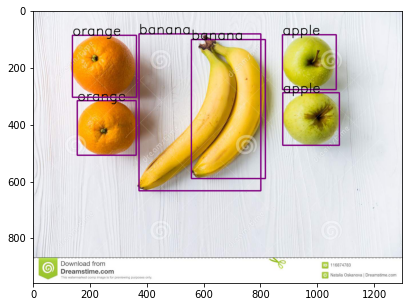

In [0]:
plot_preds(pilimg, predict)

В данном проекте попытаюсь выполнить оба сценария.
Датасет: https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection
Детекция фруктов

In [0]:
#Загрузим датасет
import gdown
gdown.download('https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM', '34662_46346_bundle_archive.zip', quiet=False)

In [0]:
#Разархивируем датасет с каггла
!unzip 34662_46346_bundle_archive.zip > /dev/null

In [0]:
#Кодируем классы
label_code = ['apple', 'orange', 'banana']

In [0]:
        def preparing_dataset(path, mode):
            path = Path(path)
            if mode == "train":
                _path = path /'train_zip'/'train'
                img_lst = list(sorted(_path.glob("*.jpg")))
                xml_lst = list(sorted(_path.glob("*.xml")))
            elif mode == "test":
                _path = path/'test_zip'/'test'
                img_lst = list(sorted(_path.glob("*.jpg")))
                xml_lst = list(sorted(_path.glob("*.xml")))
            else:
                raise ValueError('Incorrect mode')
            #список тензоров картинок
            IMG_TENS = []
            for i in img_lst:
                pil = Image.open(i).convert("RGB")
                img = tv.transforms.ToTensor()(pil).unsqueeze(0)
                IMG_TENS.append(img)
            #словарь таргетов
            label_code = ['apple', 'orange', 'banana']
            TARGET = []
            for _ in xml_lst:
                tree = ElementTree.parse(_)
                root = tree.getroot()
                name = []
                coord = []
                for element in root.iter('object'):
                    tempcoord = []
                    for child in element:
                        if child.tag == 'name':
                            name += [label_code.index(child.text)]
                        elif child.tag == 'bndbox':
                            for i in child:
                                tempcoord +=[int(i.text)]
                            coord +=[tempcoord]
                coord = torch.FloatTensor(coord)
                name = torch.IntTensor(name)
                label = {'boxes':coord , 'labels': name}
                TARGET.append(label)
            return IMG_TENS, TARGET
train_img_tens, train_target = preparing_dataset('/content', mode='train')
val_img_tens, val_target = preparing_dataset('/content', mode='test')

In [0]:
#Неоптимальная предобработка датасета, потом будет лучше.
class FrutDataset (torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x 
        self.y = y
        self.len_ = len(self.x)
    def __len__(self):
        return self.len_
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

In [0]:
#Неоптимальная предобработка датасета, потом будет лучше.
class FrutDataset (torch.utils.data.Dataset):
    def __init__(self, path, mode):
        #Предобработка сета    
        def preparing_dataset(path, mode):
            path = Path(path)
            if mode == "train":
                _path = path /'train_zip'/'train'
                img_lst = list(sorted(_path.glob("*.jpg")))
                xml_lst = list(sorted(_path.glob("*.xml")))
            elif mode == "test":
                _path = path/'test_zip'/'test'
                img_lst = list(sorted(_path.glob("*.jpg")))
                xml_lst = list(sorted(_path.glob("*.xml")))
            else:
                raise ValueError('Incorrect mode')
            #список тензоров картинок
            IMG_TENS = []
            for i in img_lst:
                pil = Image.open(i).convert("RGB")
                img = tv.transforms.ToTensor()(pil).unsqueeze(0)
                IMG_TENS.append(img)
            #словарь таргетов
            label_code = ['apple', 'orange', 'banana']
            TARGET = []
            for _ in xml_lst:
                tree = ElementTree.parse(_)
                root = tree.getroot()
                name = []
                coord = []
                for element in root.iter('object'):
                    tempcoord = []
                    for child in element:
                        if child.tag == 'name':
                            name += [label_code.index(child.text)]
                        elif child.tag == 'bndbox':
                            for i in child:
                                tempcoord +=[int(i.text)]
                            coord +=[tempcoord]
                coord = torch.FloatTensor(coord)
                name = torch.IntTensor(name)
                label = {'boxes':coord , 'labels': name}
                TARGET.append(label)
            return IMG_TENS, TARGET
        self.img_tens, self.target = preparing_dataset(path, mode)
        self.path = path
        self.mode = mode
        self.len_ = len(self.img_tens)
    def __len__(self):
        return self.len_
    def __getitem__(self, index):
        x = self.img_tens[index]
        y = self.target[index]
        return x, y

In [0]:
#Создаем обучающий и валидационный сеты
train_set = FrutDataset('/content', mode='train')
val_set = FrutDataset('/content', mode='test')

In [0]:
#Загрузчики
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [0]:
#Циклы обучения
def train_model